# L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stop words. The code is implemented as a class, `LDAGibbs`, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [1]:
import numpy, random, scipy.special
np = numpy
from tm3 import LDAGibbs
import matplotlib.pyplot as plt

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.total_tokens = 0
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = numpy.zeros(self.num_topics) # n
        self.doc_totals = numpy.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
                self.total_tokens += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations): #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
       
        for d_id, doc in enumerate(self.docs):
            
            for i, (tok, top) in enumerate(zip(doc['tokens'], doc['topics'])):
                self.term_topics[tok][top] -= 1 # n_wk
                self.doc_topics[d_id][top] -= 1 # n_dk
                self.topic_totals[top] -= 1     # n_k
                
                p_k = np.zeros(10)
                for k in range(self.num_topics):
                    p_d = alpha + self.doc_topics[d_id][k]                    
                    p_w = beta + self.term_topics[tok][k]
                    norm = self.num_terms * beta + self.topic_totals[k]
                    
                    p_k[k] = p_d * p_w / norm
                    
                #print(p_k)
                p_k = p_k/np.sum(p_k)
                #print(p_k)
                    
                z_sample = np.random.choice(self.num_topics, p=p_k)
                doc['topics'][i] = z_sample
                
                self.term_topics[tok][z_sample] += 1 # n_wk
                self.doc_topics[d_id][z_sample] += 1 # n_dk
                self.topic_totals[z_sample] += 1     # n_k
        
        #super().make_draw(alpha, beta)
            
    def print_topics(self, j):
        for k in range(self.num_topics):
            row = self.term_topics[:,k]
            top_args = np.argsort(row)[-j:][::-1]
            top_vals = row[top_args]
            
            print_str = ""
            for i, arg in enumerate(top_args):
                print_str += "{} [{}] ".format(self.vocab[arg], top_vals[i])
            print(print_str)
        #super().print_topics(j)
    
    def plot(self):
        plt.plot(self.logprobs)
        plt.show()            
    
    def compute_logprob(self, alpha, beta):
        ## TODO: implement this function for the bonus exercise
        return super().compute_logprob(alpha, beta)

        

Implement the `make_draw` function above. You should get behavior very similar to the results from calling the parent class.

In [2]:
num_topics = 10
num_iterations = 1000

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(num_iterations)

Read 2898 documents with a total of 8695 terms
iteration 0, -10.364982289782107
iteration 1, -9.83249586707413
iteration 2, -9.559827453483178
iteration 3, -9.409150130638707
iteration 4, -9.291133674615832
iteration 5, -9.206732451767392
iteration 6, -9.141125353721948
iteration 7, -9.086604728022888
iteration 8, -9.0418798761254
iteration 9, -8.992739125483455
iteration 10, -8.955936183708038
iteration 11, -8.922012441798651
iteration 12, -8.895829148994272
iteration 13, -8.876463236687353
iteration 14, -8.856272229619849
iteration 15, -8.830401024994865
iteration 16, -8.807094726432776
iteration 17, -8.79436665548731
iteration 18, -8.780799307066829
iteration 19, -8.761232063718067
iteration 20, -8.746897757277184
iteration 21, -8.729987056000372
iteration 22, -8.71620957662241
iteration 23, -8.703547819810511
iteration 24, -8.697021841881647
iteration 25, -8.684482286052784
iteration 26, -8.673571061163226
iteration 27, -8.660645399286055
iteration 28, -8.65131291861755
iteration 2

iteration 245, -8.311711721587697
iteration 246, -8.315408468657708
iteration 247, -8.314839123196034
iteration 248, -8.308602604212622
iteration 249, -8.303897876063601
iteration 250, -8.305799215416094
iteration 251, -8.313189478301856
iteration 252, -8.310385085462238
iteration 253, -8.305002248119706
iteration 254, -8.305255096238916
iteration 255, -8.301374139517018
iteration 256, -8.304737628790365
iteration 257, -8.304565150647367
iteration 258, -8.306377577536166
iteration 259, -8.31065195750764
iteration 260, -8.30815676558584
iteration 261, -8.305081836254226
iteration 262, -8.305863341416346
iteration 263, -8.30897349813903
iteration 264, -8.307050809311725
iteration 265, -8.303547100180262
iteration 266, -8.3052095094063
iteration 267, -8.307266351228177
iteration 268, -8.305330471060115
iteration 269, -8.30678812057594
iteration 270, -8.300740809301683
iteration 271, -8.304181994507687
iteration 272, -8.305122750553963
iteration 273, -8.304612591783126
iteration 274, -8.30

iteration 488, -8.292028058998973
iteration 489, -8.296605475070407
iteration 490, -8.29727293705991
iteration 491, -8.299526061197739
iteration 492, -8.293773176774115
iteration 493, -8.292300140329218
iteration 494, -8.291749773383586
iteration 495, -8.296079472991094
iteration 496, -8.29079159392282
iteration 497, -8.286572347166974
iteration 498, -8.291110578881645
iteration 499, -8.284732033829853
iteration 500, -8.291308569915529
iteration 501, -8.29476217945527
iteration 502, -8.28934164795506
iteration 503, -8.288595720723718
iteration 504, -8.293786030179005
iteration 505, -8.295366569593094
iteration 506, -8.294178982314115
iteration 507, -8.291981010641475
iteration 508, -8.292643364430964
iteration 509, -8.291568768120587
iteration 510, -8.291041987176897
iteration 511, -8.297118629591496
iteration 512, -8.292834286173017
iteration 513, -8.288409124950856
iteration 514, -8.282574649854558
iteration 515, -8.290657456243105
iteration 516, -8.291767657439788
iteration 517, -8.

iteration 731, -8.284299025383064
iteration 732, -8.281970544198623
iteration 733, -8.28490946990429
iteration 734, -8.282549248773307
iteration 735, -8.279167140368962
iteration 736, -8.280714363477385
iteration 737, -8.28283995272483
iteration 738, -8.285203422182933
iteration 739, -8.290714697224935
iteration 740, -8.286479835917419
iteration 741, -8.28228884605578
iteration 742, -8.28281135223416
iteration 743, -8.281245700297658
iteration 744, -8.281243501396164
iteration 745, -8.287860066460436
iteration 746, -8.288938973610115
iteration 747, -8.284959734283195
iteration 748, -8.28270305842579
iteration 749, -8.285613945471841
iteration 750, -8.288586837462288
iteration 751, -8.285513537241526
iteration 752, -8.281481646362307
iteration 753, -8.277879675619038
iteration 754, -8.280355214998895
iteration 755, -8.284645295752414
iteration 756, -8.282427945742361
iteration 757, -8.282431997805645
iteration 758, -8.283532269677469
iteration 759, -8.281782809367332
iteration 760, -8.2

iteration 974, -8.280761420046538
iteration 975, -8.277272904497707
iteration 976, -8.28133425806261
iteration 977, -8.277909384933212
iteration 978, -8.27999402662299
iteration 979, -8.280402626430469
iteration 980, -8.275208485137348
iteration 981, -8.28668553130731
iteration 982, -8.290862250483201
iteration 983, -8.287204295722209
iteration 984, -8.28186787229404
iteration 985, -8.290183792035299
iteration 986, -8.281664031561595
iteration 987, -8.28463410931319
iteration 988, -8.28221967146583
iteration 989, -8.283259849553998
iteration 990, -8.280411753128648
iteration 991, -8.286076003727565
iteration 992, -8.289190369661984
iteration 993, -8.28409546801408
iteration 994, -8.283595820560977
iteration 995, -8.286047086147073
iteration 996, -8.285646542005821
iteration 997, -8.281870320202836
iteration 998, -8.284523780827302
iteration 999, -8.286116034863975


### 2. Top terms
Implement the `print_topics` function to extract the top `j` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [3]:
model.print_topics(10)

federal [181.0] congress [180.0] administration [174.0] energy [173.0] programs [132.0] government [129.0] program [102.0] act [93.0] policy [85.0] nation [84.0] 
security [115.0] forces [114.0] soviet [110.0] military [105.0] defense [87.0] world [81.0] united [65.0] strong [64.0] strategic [61.0] national [60.0] 
technology [61.0] century [61.0] space [52.0] environment [52.0] national [50.0] america [47.0] science [45.0] research [44.0] god [41.0] generation [31.0] 
people [126.0] president [125.0] congress [115.0] american [87.0] tonight [76.0] country [68.0] house [67.0] mr [60.0] members [57.0] years [53.0] 
budget [207.0] years [205.0] year [193.0] percent [157.0] spending [135.0] billion [132.0] federal [132.0] million [110.0] government [106.0] tax [105.0] 
world [177.0] nuclear [122.0] international [114.0] nations [114.0] states [103.0] peace [100.0] united [95.0] countries [90.0] rights [76.0] human [66.0] 
children [144.0] education [111.0] crime [98.0] schools [96.0] scho

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

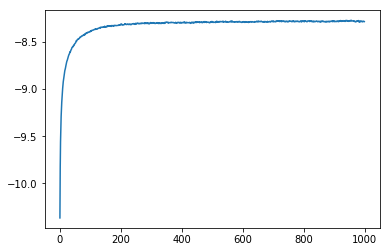

In [4]:
%matplotlib inline
model.plot()

#### Answer here:

First topic: General domestic administration topic

Second topic: National security and military

Third topic: Science and technology

Fourth topic: House meetings

Fifth topic: Economy

Sixth topic: International affairs and human rights

Seventh topic: Education and work

Eighth topic: murica

Nineth topic: Healthcare and general welfare

Tenth topic: Business and trade

### 4. Simulate a new State of the Union speech

Write a function `new_speech` using the `MyGibbs` class to use the estimated values for $\Phi$ from your model (with stop words removed) to simulate a new State of the Union speech. Start out by simulating $\theta_d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [5]:
def new_speech(model, alpha, num_words):
    theta = np.random.dirichlet([alpha]*model.num_topics)
    
    speech = []
    
    for i in range(num_words):
        z = np.random.choice(model.num_topics, p=theta)        
        p = model.term_topics[:,z]/np.sum(model.term_topics[:,z])
        
        index = np.random.choice(model.num_terms, p=p)
        
        speech.append( model.vocab[index] )
        
    return " ".join(speech)

In [6]:
new_speech(model, 0.5, 100)

'avoid today petroleum congress number greatest scholarship carry leaders important priority aid resorted decent white combine preventing traffickers separation east coal reform achieve policies localities federal east 20 earn constructive land administration determined continue percent kenya housing cabinet white negotiated children person targets start congress gramm country systems process 2 year process developing flexibility facilities weapons disability resources working devastating national programs commission pay demands persecution great communities financial states federal 1980 services urban assistance energy kind result world destroyer send proposed partnership study policy achieve 1977 cut cooperation oil billion system ll significant propose agencies confirmation greater jobs countries'

#### Answer here:
The speech does not make sense. We have no structure included in our model. There is no syntax etc. Currently we just sample common words from topics independently. 

### Bonus assignment:

To get better understanding how to implement the underlying model or similar models, you might want to implement your own function to compute the log marginal posterior. If so, implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).

In [9]:
arr1 = np.random.dirichlet([0.5]*10)
z = np.random.choice(10, p=arr1)

p = model.term_topics[:,z]/np.sum(model.term_topics[:,z])


np.random.choice("num_words", p=p)

ValueError: a must be 1-dimensional or an integer